# NetraEmbed Inference Demo

**🚀 Universal Multilingual Multimodal Document Retrieval**

This notebook provides code for inferencing **NetraEmbed**, a single-vector embedding model with Matryoshka representation for fast retrieval with cosine similarity. 

**Links:**
- 📄 [Paper](https://arxiv.org/abs/2512.03514)
- 💻 [GitHub](https://github.com/adithya-s-k/colpali)
- 🤗 [HuggingFace Model](https://huggingface.co/Cognitive-Lab/NetraEmbed)
- 📝 [Blog](https://www.cognitivelab.in/blog/introducing-netraembed)

---

**⚠️ IMPORTANT: Set Runtime to GPU (L4 or A100 recommended, can run on T4 with smaller batch sizes)**

Go to `Runtime` → `Change runtime type` → Select `T4 GPU`, `L4 GPU` or `A100 GPU`

## 1. Install Dependencies

In [1]:
# Install required packages
!uv pip install --system git+https://github.com/adithya-s-k/colpali.git
!uv pip install --system pdf2image Pillow requests bitsandbytes
!apt-get install -y poppler-utils  # For PDF to image conversion

print("✅ Installation complete!")

Using Python 3.12.12 environment at: /usr
Resolved 47 packages in 3.71s
Prepared 17 packages in 52.43s
Uninstalled 16 packages in 570ms
Installed 17 packages in 218ms
 + colpali-engine==0.1.dev261+g89d0ddf4c (from git+https://github.com/adithya-s-k/colpali.git@89d0ddf4cbc1e2e571e7e383d3fa3d99217caa69)
 - nvidia-cublas-cu12==12.6.4.1
 + nvidia-cublas-cu12==12.8.4.1
 - nvidia-cuda-cupti-cu12==12.6.80
 + nvidia-cuda-cupti-cu12==12.8.90
 - nvidia-cuda-nvrtc-cu12==12.6.77
 + nvidia-cuda-nvrtc-cu12==12.8.93
 - nvidia-cuda-runtime-cu12==12.6.77
 + nvidia-cuda-runtime-cu12==12.8.90
 - nvidia-cufft-cu12==11.3.0.4
 + nvidia-cufft-cu12==11.3.3.83
 - nvidia-cufile-cu12==1.11.1.6
 + nvidia-cufile-cu12==1.13.1.3
 - nvidia-curand-cu12==10.3.7.77
 + nvidia-curand-cu12==10.3.9.90
 - nvidia-cusolver-cu12==11.7.1.2
 + nvidia-cusolver-cu12==11.7.3.90
 - nvidia-cusparse-cu12==12.5.4.2
 + nvidia-cusparse-cu12==12.5.8.93
 - nvidia-nccl-cu12==2.27.5
 + nvidia-nccl-cu12==2.27.3
 - nvidia-nvjitlink-cu12==12.6.8

## 2. Import Libraries and Setup

In [2]:
import torch
from pdf2image import convert_from_path
import requests
from transformers import BitsAndBytesConfig

# Import NetraEmbed (BiGemma3) from colpali_engine
from colpali_engine.models import BiGemma3, BiGemmaProcessor3

# Check GPU availability
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Device: {device}")
gpu_memory = 0.0
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    gpu_memory = torch.cuda.get_device_properties(0).total_memory / 1e9
    print(f"GPU Memory: {gpu_memory:.2f} GB")
else:
    print("⚠️ WARNING: GPU not available! We recommend running this notebook on a GPU")

print("✅ Imports complete!")

Device: cuda
GPU: Tesla T4
GPU Memory: 15.83 GB
✅ Imports complete!


## 3. Load NetraEmbed Model

In [3]:
model_name = "Cognitive-Lab/NetraEmbed"

print(f"Loading {model_name}...")
print("(This may take 2-3 minutes on first load, ~30 seconds if cached)\n")

# Load processor
processor = BiGemmaProcessor3.from_pretrained(
    model_name,
    use_fast=True,
)

# Load model
model = BiGemma3.from_pretrained(
    model_name,
    dtype=torch.bfloat16,
    device_map=device,
)
model.eval()

print("✅ NetraEmbed loaded successfully!")
print("   - Supports Matryoshka dimensions: 768, 1536, 2560")
print(f"   - Device: {model.device}")
print(f"   - Dtype: {model.dtype}")

Loading Cognitive-Lab/NetraEmbed...
(This may take 2-3 minutes on first load, ~30 seconds if cached)



preprocessor_config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

processor_config.json:   0%|          | 0.00/70.0 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.model:   0%|          | 0.00/4.69M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/33.4M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/35.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/662 [00:00<?, ?B/s]

chat_template.jinja: 0.00B [00:00, ?B/s]

chat_template.json: 0.00B [00:00, ?B/s]

config.json: 0.00B [00:00, ?B/s]

model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.96G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/3.64G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

✅ NetraEmbed loaded successfully!
   - Supports Matryoshka dimensions: 768, 1536, 2560
   - Device: cuda:0
   - Dtype: torch.bfloat16


## 4. Download Sample PDF

We'll download a famous PDF - the Attention Is All You Need paper (Transformer paper)

In [4]:
# Download a famous paper PDF
pdf_url = "https://arxiv.org/pdf/1706.03762.pdf"  # Attention Is All You Need
pdf_path = "attention_paper.pdf"

print(f"Downloading PDF from {pdf_url}...")
response = requests.get(pdf_url)
with open(pdf_path, 'wb') as f:
    f.write(response.content)

print(f"✅ PDF downloaded: {pdf_path}")

✅ PDF downloaded: attention_paper.pdf


## 5. Convert PDF to Images

Converting PDF to images...
✅ Converted 15 pages to images
   Image size: (1700, 2200)

Preview of first page:


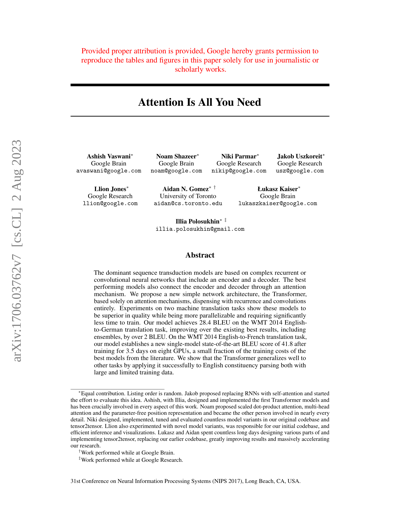

In [5]:
print("Converting PDF to images...")
images = convert_from_path(pdf_path, dpi=200)

print(f"✅ Converted {len(images)} pages to images")
print(f"   Image size: {images[0].size}")

# Display first page
print("\nPreview of first page:")
display(images[0].resize((400, int(400 * images[0].height / images[0].width))))

## 6. Encode Document Pages

We'll encode all pages into embeddings. Using 768-dimensional embeddings for faster retrieval.

In [6]:
# Choose embedding dimension (768 for fast retrieval, 2560 for highest quality)
embedding_dim = 768

# Process in batches to avoid OOM issues on GPUs with less than 16GB VRAM
# You can increase this if you have more VRAM available
batch_size = 2

print(f"Encoding {len(images)} pages with embedding_dim={embedding_dim}...")
print(f"Processing in batches of {batch_size} to save memory\n")

# Process images in batches
image_embeddings_list = []

for i in range(0, len(images), batch_size):
    batch = images[i:i + batch_size]
    print(f"Processing batch {i//batch_size + 1}/{(len(images) + batch_size - 1)//batch_size}: pages {i+1}-{min(i+batch_size, len(images))}")

    # Process batch
    batch_images = processor.process_images(batch).to(device)

    # Generate embeddings
    with torch.no_grad():
        batch_embeddings = model(**batch_images, embedding_dim=embedding_dim)

    image_embeddings_list.append(batch_embeddings.cpu())

    # Clear GPU memory after each batch
    del batch_images, batch_embeddings
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

# Concatenate all embeddings
image_embeddings = torch.cat(image_embeddings_list, dim=0).to(device)

print("\n✅ Images encoded successfully!")
print(f"   - Embedding shape: {image_embeddings.shape}")
print("   - Shape format: (num_images, embedding_dim)")
print(f"   - Dtype: {image_embeddings.dtype}")

Encoding 15 pages with embedding_dim=768...
Processing in batches of 2 to save memory

Processing batch 1/8: pages 1-2
Processing batch 2/8: pages 3-4
Processing batch 3/8: pages 5-6
Processing batch 4/8: pages 7-8
Processing batch 5/8: pages 9-10
Processing batch 6/8: pages 11-12
Processing batch 7/8: pages 13-14
Processing batch 8/8: pages 15-15

✅ Images encoded successfully!
   - Embedding shape: torch.Size([15, 768])
   - Shape format: (num_images, embedding_dim)
   - Dtype: torch.bfloat16


## 7. Query the Document

Let's search for specific content in the document!

In [7]:
# Define your query
query = "positional encoding"

print(f"Query: '{query}'\n")

# Encode query
batch_query = processor.process_texts([query]).to(device)

with torch.no_grad():
    query_embedding = model(**batch_query, embedding_dim=embedding_dim)

print("✅ Query encoded!")
print(f"   - Query embedding shape: {query_embedding.shape}")

Query: 'positional encoding'

✅ Query encoded!
   - Query embedding shape: torch.Size([1, 768])


## 8. Compute Similarity and Retrieve Top Pages

In [8]:
# Compute cosine similarity scores
scores = processor.score(
    qs=query_embedding,
    ps=image_embeddings,
)

print(f"Similarity scores shape: {scores.shape}")
print(f"Scores: {scores[0].tolist()}\n")

# Get top result
top_k = 2
top_indices = scores[0].argsort(descending=True)[:top_k]

print(f"\n🔍 Top {top_k} Results for query: '{query}'\n")
print("=" * 60)

for rank, idx in enumerate(top_indices, 1):
    score = scores[0, idx].item()
    print(f"Rank {rank}: Page {idx.item() + 1} - Similarity Score: {score:.4f}")

print("=" * 60)

Similarity scores shape: torch.Size([1, 15])
Scores: [0.310546875, 0.392578125, 0.384765625, 0.23828125, 0.408203125, 0.4375, 0.28515625, 0.2099609375, 0.306640625, 0.251953125, 0.2431640625, 0.2578125, 0.23828125, 0.1552734375, 0.318359375]


🔍 Top 2 Results for query: 'positional encoding'

Rank 1: Page 6 - Similarity Score: 0.4375
Rank 2: Page 5 - Similarity Score: 0.4082


## 9. Visualize Top Retrieved Pages


🔍 Top 2 Retrieved Pages for: 'positional encoding'


──────────────────────────────────────────────────────────────────────
📄 Rank 1: Page 6 - Similarity Score: 0.4375
──────────────────────────────────────────────────────────────────────


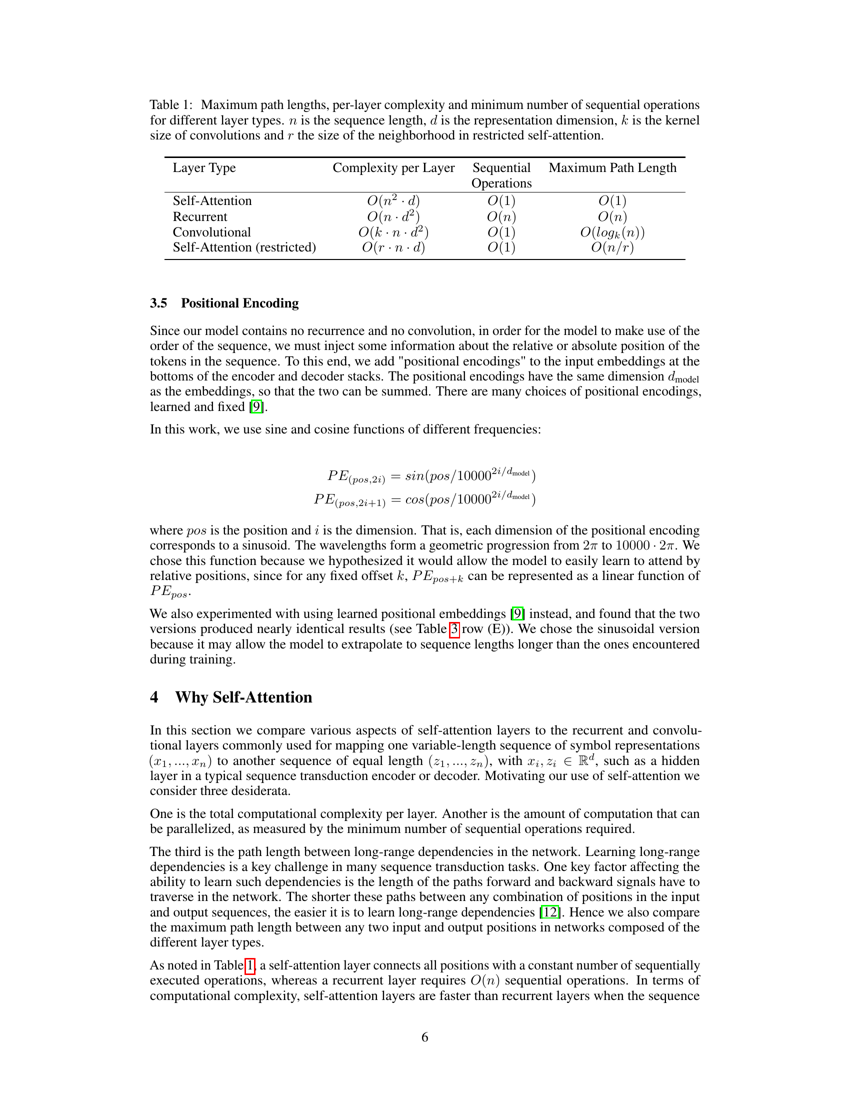


──────────────────────────────────────────────────────────────────────
📄 Rank 2: Page 5 - Similarity Score: 0.4082
──────────────────────────────────────────────────────────────────────


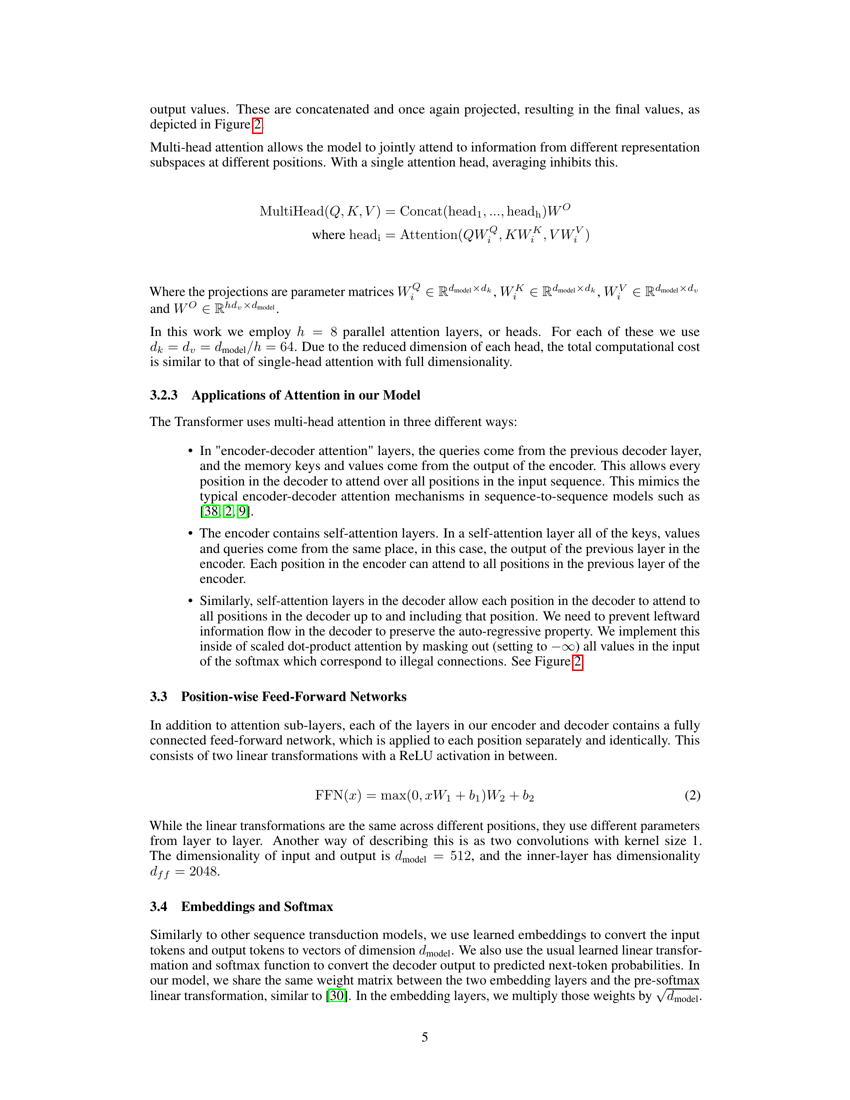

In [9]:
from IPython.display import display, HTML

# Display top 3 pages directly
print(f"\n{'='*70}")
print(f"🔍 Top {top_k} Retrieved Pages for: '{query}'")
print(f"{'='*70}\n")

for i, idx in enumerate(top_indices):
    score = scores[0, idx].item()
    page_num = idx.item() + 1

    print(f"\n{'─'*70}")
    print(f"📄 Rank {i+1}: Page {page_num} - Similarity Score: {score:.4f}")
    print(f"{'─'*70}")

    # Display the image at half width
    img = images[idx.item()]

    new_width = img.width // 2
    new_height = img.height // 2
    display(img.resize((new_width, new_height)))

## 10. Try Your Own Queries!

Modify the query below and run to search for different content:


🔍 Searching for: 'multi-head attention'

──────────────────────────────────────────────────────────────────────
📄 Rank 1: Page 2 - Similarity Score: 0.4062
──────────────────────────────────────────────────────────────────────


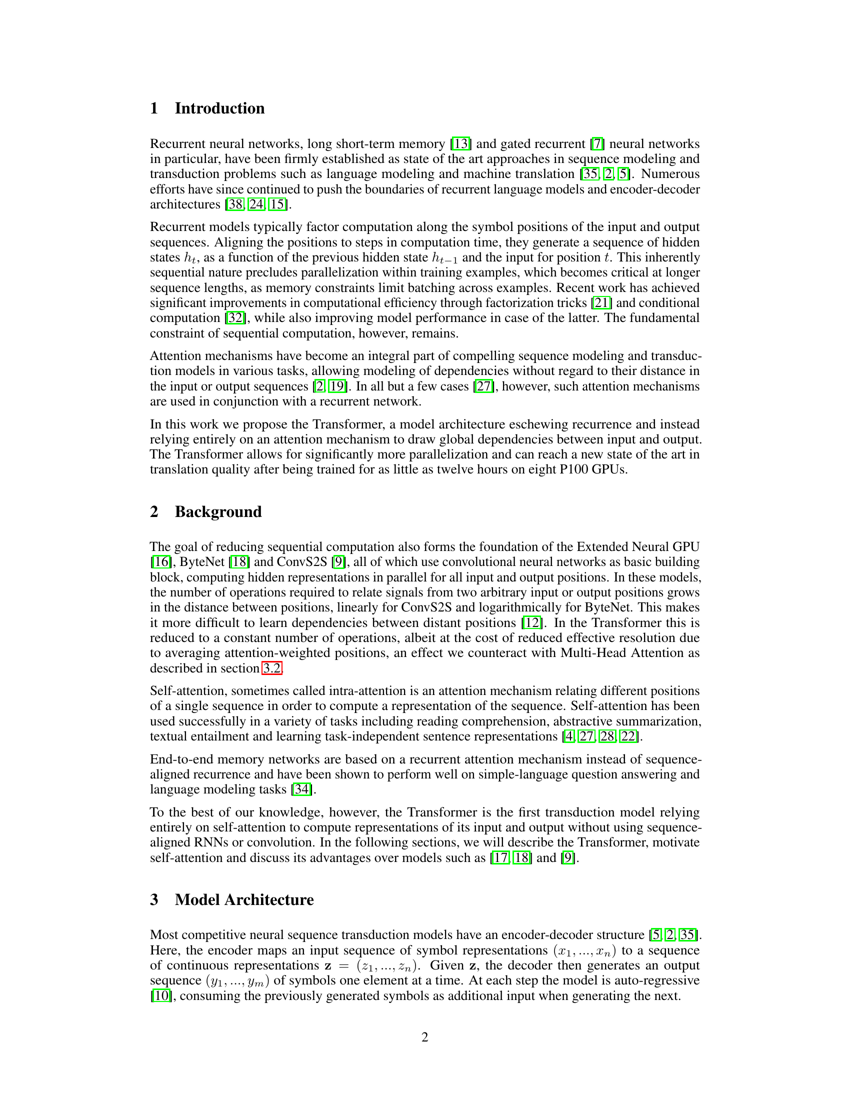


──────────────────────────────────────────────────────────────────────
📄 Rank 2: Page 1 - Similarity Score: 0.4062
──────────────────────────────────────────────────────────────────────


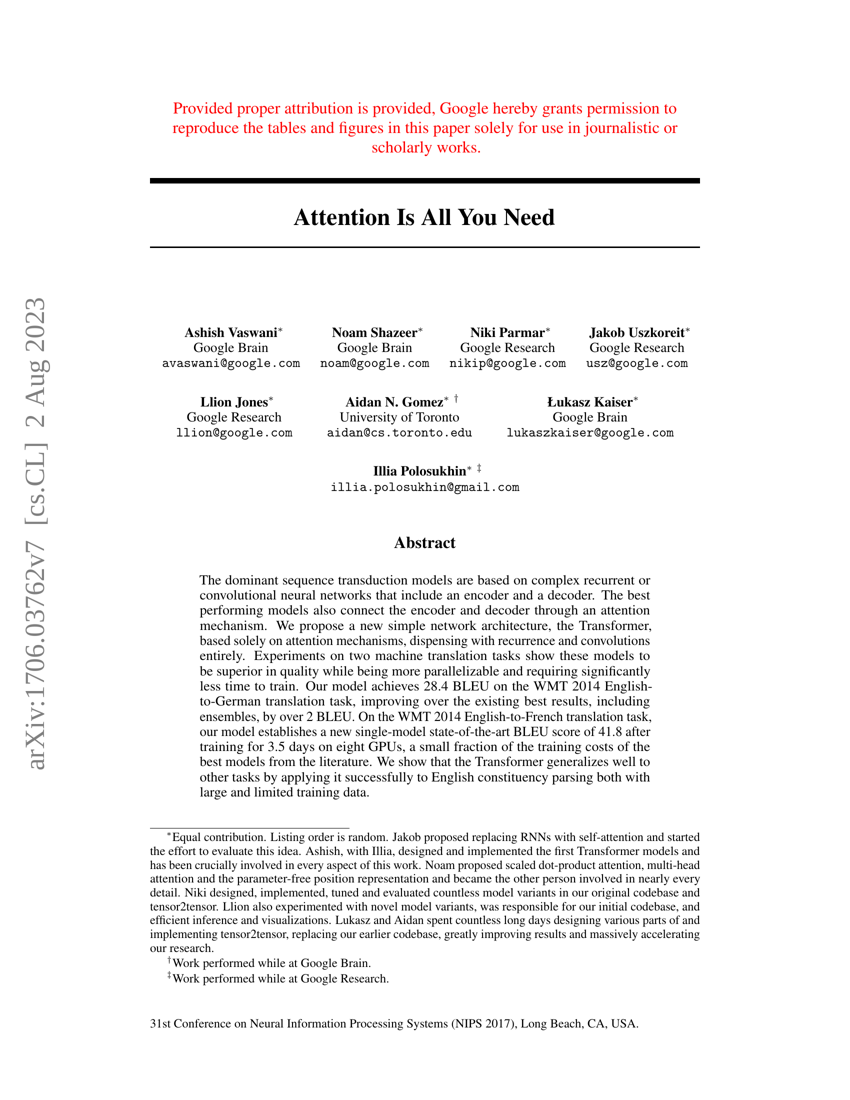


──────────────────────────────────────────────────────────────────────
📄 Rank 3: Page 3 - Similarity Score: 0.4004
──────────────────────────────────────────────────────────────────────


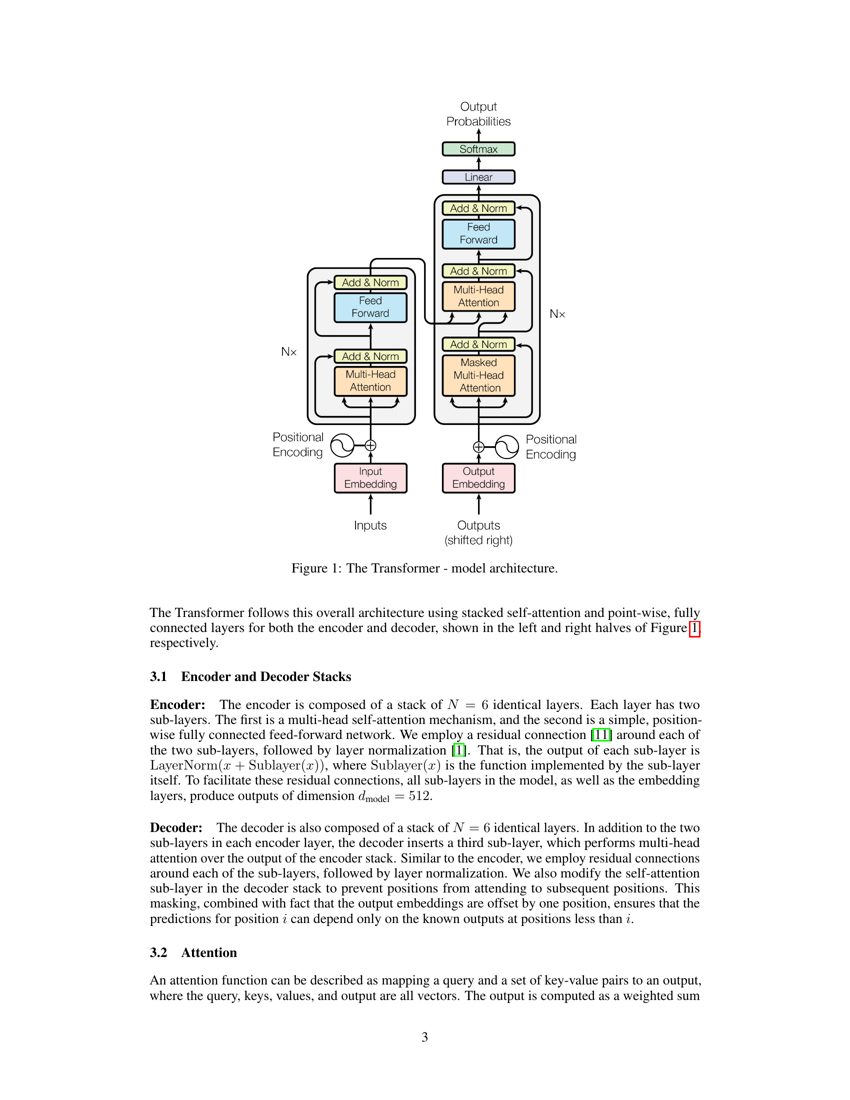

In [10]:
from IPython.display import display

def search_document(query_text, top_k=3, show_images=True):
    """Search the document with a custom query."""
    print(f"\n{'='*70}")
    print(f"🔍 Searching for: '{query_text}'")
    print(f"{'='*70}")

    # Encode query
    batch_query = processor.process_texts([query_text]).to(device)
    with torch.no_grad():
        query_emb = model(**batch_query, embedding_dim=embedding_dim)

    # Compute scores
    scores = processor.score(qs=query_emb, ps=image_embeddings)
    top_indices = scores[0].argsort(descending=True)[:top_k]

    # Print and display results
    for rank, idx in enumerate(top_indices, 1):
        score = scores[0, idx].item()
        page_num = idx.item() + 1

        print(f"\n{'─'*70}")
        print(f"📄 Rank {rank}: Page {page_num} - Similarity Score: {score:.4f}")
        print(f"{'─'*70}")

        if show_images:
            img = images[idx.item()]
            new_width = img.width // 2
            new_height = img.height // 2
            display(img.resize((new_width, new_height)))

# Try different queries:
search_document("multi-head attention", top_k=3)

## Next Steps:
- Try with your own PDFs
- Experiment with different embedding dimensions (768, 1536, 2560)
- Test multilingual queries
- Check out ColNetraEmbed for multi-vector embeddings with heatmaps!

**Learn More:**
- [Full Documentation](https://github.com/adithya-s-k/colpali)
- [Paper](https://arxiv.org/abs/2512.03514)
- [Model Card](https://huggingface.co/Cognitive-Lab/NetraEmbed)